# Find rain days in a specified region, given 8 upper atm variables and respective Gridmet data.

This notebook calculates average rain on a 128x128 grid, it then averages the respective 8 upper atm variables. 

* this version loads netcdf files directly via xarray
* "Gridmet data" can now be replaced with any model's output

### TODO items

* better graphs (i.e. include lat/lon scale)



In [1]:
from IPython import display
import numpy as np

#from skimage.metrics import structural_similarity as ssim
import copy


In [2]:
# load netcdf files directly via xarray
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy

# Configuration

In [3]:
# Ordering: nRow ordering: obs, raw, RegCM4, WRF, MPAS, CNN, SDSM, KDDM, MBCn, LOCA
mpi_sigfiles=['/glade/work/mcginnis/DCA/data/gen/final/gridmet/hist/prec.hist.gridMET.obs.day.1980-2005.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/mpi/hist/prec.hist.MPI-ESM-LR.raw.day.1980-2005.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/mpi/rcp85/prec.rcp85.MPI-ESM-LR.raw.day.2075-2100.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/regcm4/hist/prec.hist.MPI-ESM-LR.RegCM4.day.1980-2005.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/regcm4/rcp85/prec.rcp85.MPI-ESM-LR.RegCM4.day.2075-2100.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/wrf/hist/prec.hist.MPI-ESM-LR.WRF.day.1980-2005.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/wrf/rcp85/prec.rcp85.MPI-ESM-LR.WRF.day.2075-2100.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/mpas/hist/prec.hist.MPI-ESM-LR.MPAS.day.1980-2005.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/mpas/rcp85/prec.rcp85.MPI-ESM-LR.MPAS.day.2075-2100.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/cnn/hist/prec.hist.MPI-ESM-LR.CNN.day.1980-2005.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/cnn/rcp85/prec.rcp85.MPI-ESM-LR.CNN.day.2075-2100.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/sdsm/hist/prec.hist.MPI-ESM-LR.SDSM.day.1976-2005.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/sdsm/rcp85/prec.rcp85.MPI-ESM-LR.SDSM.day.2070-2099.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/kddm/hist/prec.hist.MPI-ESM-LR.KDDM.day.1980-2005.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/kddm/rcp85/prec.rcp85.MPI-ESM-LR.KDDM.day.2075-2100.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/mbcn/hist/prec.hist.MPI-ESM-LR.MBCn.day.1980-2005.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/mbcn/rcp85/prec.rcp85.MPI-ESM-LR.MBCn.day.2075-2100.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/loca/hist/prec.hist.MPI-ESM-LR.LOCA.day.1980-2005.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/loca/rcp85/prec.rcp85.MPI-ESM-LR.LOCA.day.2075-2100.NAM-22i.SGP.x098.y36.nc']

# Compact Configuration

In [4]:
sigdir = '/glade/work/mcginnis/DCA/data/gen/final'
def model2absfilepath(mn, exp, x, y):
    if mn == 'obs' or mn == 'gridMET':
        mn = 'gridMET'
        filename = 'prec.{}.gridMET.{}.day.1980-2005.NAM-22i.SGP.x0{}.y{}.nc'.format(exp, 'obs', x, y)
    elif mn == 'raw' or mn == 'mpi':
        mn = 'mpi'
        if exp == 'hist':
            filename = 'prec.{}.MPI-ESM-LR.{}.day.1980-2005.NAM-22i.SGP.x0{}.y{}.nc'.format(exp, 'raw', x, y)
        elif exp == 'rcp85':
            filename = 'prec.{}.MPI-ESM-LR.{}.day.2075-2100.NAM-22i.SGP.x0{}.y{}.nc'.format(exp, 'raw', x, y)
        else: print("Unknown experiment!")
    elif mn == 'SDSM':  # starts at 1976
        if exp == 'hist':
            filename = 'prec.{}.MPI-ESM-LR.{}.day.1976-2005.NAM-22i.SGP.x0{}.y{}.nc'.format(exp, mn, x, y)
        elif exp == 'rcp85':
            filename = 'prec.{}.MPI-ESM-LR.{}.day.2070-2099.NAM-22i.SGP.x0{}.y{}.nc'.format(exp, mn, x, y)
        else: print("Unknown experiment!")

    elif exp == 'hist':
        filename = 'prec.{}.MPI-ESM-LR.{}.day.1980-2005.NAM-22i.SGP.x0{}.y{}.nc'.format(exp, mn, x, y)
    elif exp == 'rcp85':
        filename = 'prec.{}.MPI-ESM-LR.{}.day.2075-2100.NAM-22i.SGP.x0{}.y{}.nc'.format(exp, mn, x, y)
    else: print("Unknown experiment!")
    return sigdir + '/' + mn.lower() + '/' + exp + '/' + filename
    

In [5]:
# test single file
model2absfilepath('RegCM4', 'rcp85', 98, 36)

'/glade/work/mcginnis/DCA/data/gen/final/regcm4/rcp85/prec.rcp85.MPI-ESM-LR.RegCM4.day.2075-2100.NAM-22i.SGP.x098.y36.nc'

In [6]:
# create list of abs filepaths
[model2absfilepath(ff, 'hist', 98, 36) for ff in ['obs','raw','RegCM4','WRF','MPAS','CNN','SDSM','KDDM','MBCn','LOCA']]


['/glade/work/mcginnis/DCA/data/gen/final/gridmet/hist/prec.hist.gridMET.obs.day.1980-2005.NAM-22i.SGP.x098.y36.nc',
 '/glade/work/mcginnis/DCA/data/gen/final/mpi/hist/prec.hist.MPI-ESM-LR.raw.day.1980-2005.NAM-22i.SGP.x098.y36.nc',
 '/glade/work/mcginnis/DCA/data/gen/final/regcm4/hist/prec.hist.MPI-ESM-LR.RegCM4.day.1980-2005.NAM-22i.SGP.x098.y36.nc',
 '/glade/work/mcginnis/DCA/data/gen/final/wrf/hist/prec.hist.MPI-ESM-LR.WRF.day.1980-2005.NAM-22i.SGP.x098.y36.nc',
 '/glade/work/mcginnis/DCA/data/gen/final/mpas/hist/prec.hist.MPI-ESM-LR.MPAS.day.1980-2005.NAM-22i.SGP.x098.y36.nc',
 '/glade/work/mcginnis/DCA/data/gen/final/cnn/hist/prec.hist.MPI-ESM-LR.CNN.day.1980-2005.NAM-22i.SGP.x098.y36.nc',
 '/glade/work/mcginnis/DCA/data/gen/final/sdsm/hist/prec.hist.MPI-ESM-LR.SDSM.day.1976-2005.NAM-22i.SGP.x098.y36.nc',
 '/glade/work/mcginnis/DCA/data/gen/final/kddm/hist/prec.hist.MPI-ESM-LR.KDDM.day.1980-2005.NAM-22i.SGP.x098.y36.nc',
 '/glade/work/mcginnis/DCA/data/gen/final/mbcn/hist/prec.hi

### Load model output data

In [7]:
##################
## LOAD GRIDMET ##
##################
# 1980-1989
istart = 365
#ndays = 3653  # 1980-1989
ndays = 13515 # 1980-2016 

dv1 = xr.open_dataset('/glade/work/dkorytin/srgan_data/prec128_gridmetA_1979-2016.nc')['prec'][istart:istart+ndays]
# dv2 = xr.open_dataset('/glade/work/dkorytin/srgan_data/tmax128_gridmetA_1979-2016.nc')['tmax'][istart:istart+ndays]
# dv3 = xr.open_dataset('/glade/work/dkorytin/srgan_data/tmin128_gridmetA_1979-2016.nc')['tmin'][istart:istart+ndays]
# dv4 = xr.open_dataset('/glade/work/dkorytin/srgan_data/uas128_gridmetA_1979-2016.nc')['uas'][istart:istart+ndays]
# dv5 = xr.open_dataset('/glade/work/dkorytin/srgan_data/vas128_gridmetA_1979-2016.nc')['vas'][istart:istart+ndays]
# dv6 = xr.open_dataset('/glade/work/dkorytin/srgan_data/huss128_gridmetA_1979-2016.nc')['huss'][istart:istart+ndays]
# dv7 = xr.open_dataset('/glade/work/dkorytin/srgan_data/rsds128_gridmetA_1979-2016.nc')['rsds'][istart:istart+ndays]
# dv8 = xr.open_dataset('/glade/work/dkorytin/srgan_data/miss128_gridmetB_1979-2016.nc')['miss'][istart:istart+ndays]




### Load MPI UATM data

In [8]:
###########################
## LOAD ERAI data: daily ##
###########################
def load_uatm_erai():
    global mdv1,mdv2,mdv3,mdv4,mdv5,mdv6,mdv7,mdv8,mnvars
    
    # load eraionmpi
    #mndays = 11688      # 1979-2010
    mstart = 365
    mndays = 13515       # 1980-2016 
    mnvars = 8*1
    mdv1 = xr.open_dataset('/glade/scratch/dkorytin/erai-on-mpigrid/U850.ERAI.MPIGRID.1979-2018.nc')['U'][mstart:mstart+mndays*1]
    mdv2 = xr.open_dataset('/glade/scratch/dkorytin/erai-on-mpigrid/V850.ERAI.MPIGRID.1979-2018.nc')['V'][mstart:mstart+mndays*1]
    mdv3 = xr.open_dataset('/glade/scratch/dkorytin/erai-on-mpigrid/Q850.ERAI.MPIGRID.1979-2018.nc')['Q'][mstart:mstart+mndays*1]
    mdv4 = xr.open_dataset('/glade/scratch/dkorytin/erai-on-mpigrid/T700.ERAI.MPIGRID.1979-2018.nc')['T'][mstart:mstart+mndays*1]
    mdv5 = xr.open_dataset('/glade/scratch/dkorytin/erai-on-mpigrid/Z700.ERAI.MPIGRID.1979-2018.nc')['Z'][mstart:mstart+mndays*1]
    mdv6 = xr.open_dataset('/glade/scratch/dkorytin/erai-on-mpigrid/Z500.ERAI.MPIGRID.1979-2018.nc')['Z'][mstart:mstart+mndays*1]
    mdv7 = xr.open_dataset('/glade/scratch/dkorytin/erai-on-mpigrid/U250.ERAI.MPIGRID.1979-2018.nc')['U'][mstart:mstart+mndays*1]
    mdv8 = xr.open_dataset('/glade/scratch/dkorytin/erai-on-mpigrid/V250.ERAI.MPIGRID.1979-2018.nc')['V'][mstart:mstart+mndays*1]

    print("Days loaded", len(mdv7))


In [9]:
###################
## LOAD MPI      ##
###################  
def load_uatm_mpi_hist():
    global mdv1,mdv2,mdv3,mdv4,mdv5,mdv6,mdv7,mdv8,mnvars
    
    mnvars = 8
    
    d='/glade/p/ral/risc/rmccrary/CMIP5_CORDEX/NAmerica/MPI-ESM-LR/native/historical/'

    mdv1 = xr.open_dataset(d+'U_MPI-ESM-LR_historical_r1i1p1_NAmerica_p850_19500101-20051231_dayavg_mpigrid.nc')['U'].sel(time=slice('1976-01-01T00:00:00', '2006-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv2 = xr.open_dataset(d+'V_MPI-ESM-LR_historical_r1i1p1_NAmerica_p850_19500101-20051231_dayavg_mpigrid.nc')['V'].sel(time=slice('1976-01-01T00:00:00', '2006-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv3 = xr.open_dataset(d+'Q_MPI-ESM-LR_historical_r1i1p1_NAmerica_p850_19500101-20051231_dayavg_mpigrid.nc')['Q'].sel(time=slice('1976-01-01T00:00:00', '2006-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv4 = xr.open_dataset(d+'T_MPI-ESM-LR_historical_r1i1p1_NAmerica_p700_19500101-20051231_dayavg_mpigrid.nc')['T'].sel(time=slice('1976-01-01T00:00:00', '2006-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv5 = xr.open_dataset(d+'Z_MPI-ESM-LR_historical_r1i1p1_NAmerica_p700_19500101-20051231_dayavg_mpigrid.nc')['Z'].sel(time=slice('1976-01-01T00:00:00', '2006-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv6 = xr.open_dataset(d+'Z_MPI-ESM-LR_historical_r1i1p1_NAmerica_p500_19500101-20051231_dayavg_mpigrid.nc')['Z'].sel(time=slice('1976-01-01T00:00:00', '2006-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv7 = xr.open_dataset(d+'U_MPI-ESM-LR_historical_r1i1p1_NAmerica_p250_19500101-20051231_dayavg_mpigrid.nc')['U'].sel(time=slice('1976-01-01T00:00:00', '2006-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv8 = xr.open_dataset(d+'V_MPI-ESM-LR_historical_r1i1p1_NAmerica_p250_19500101-20051231_dayavg_mpigrid.nc')['V'].sel(time=slice('1976-01-01T00:00:00', '2006-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))

def load_uatm_mpi_future():
    global mdv1,mdv2,mdv3,mdv4,mdv5,mdv6,mdv7,mdv8,mnvars
    
    d='/glade/p/ral/risc/rmccrary/CMIP5_CORDEX/NAmerica/MPI-ESM-LR/native/rcp85/'

    mnvars = 8
    mdv1 = xr.open_dataset(d+'U_MPI-ESM-LR_rcp85_r1i1p1_NAmerica_p850_20060101-21001231_dayavg_mpigrid.nc')['U'].sel(time=slice('2006-01-01T00:00:00', '2101-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv2 = xr.open_dataset(d+'V_MPI-ESM-LR_rcp85_r1i1p1_NAmerica_p850_20060101-21001231_dayavg_mpigrid.nc')['V'].sel(time=slice('2006-01-01T00:00:00', '2101-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv3 = xr.open_dataset(d+'Q_MPI-ESM-LR_rcp85_r1i1p1_NAmerica_p850_20060101-21001231_dayavg_mpigrid.nc')['Q'].sel(time=slice('2006-01-01T00:00:00', '2101-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv4 = xr.open_dataset(d+'T_MPI-ESM-LR_rcp85_r1i1p1_NAmerica_p700_20060101-21001231_dayavg_mpigrid.nc')['T'].sel(time=slice('2006-01-01T00:00:00', '2101-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv5 = xr.open_dataset(d+'Z_MPI-ESM-LR_rcp85_r1i1p1_NAmerica_p700_20060101-21001231_dayavg_mpigrid.nc')['Z'].sel(time=slice('2006-01-01T00:00:00', '2101-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv6 = xr.open_dataset(d+'Z_MPI-ESM-LR_rcp85_r1i1p1_NAmerica_p500_20060101-21001231_dayavg_mpigrid.nc')['Z'].sel(time=slice('2006-01-01T00:00:00', '2101-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv7 = xr.open_dataset(d+'U_MPI-ESM-LR_rcp85_r1i1p1_NAmerica_p250_20060101-21001231_dayavg_mpigrid.nc')['U'].sel(time=slice('2006-01-01T00:00:00', '2101-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv8 = xr.open_dataset(d+'V_MPI-ESM-LR_rcp85_r1i1p1_NAmerica_p250_20060101-21001231_dayavg_mpigrid.nc')['V'].sel(time=slice('2006-01-01T00:00:00', '2101-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))

#load_uatm_mpi_future()


# Averaging code

In [14]:
###################
## UATM averages ##
###################

def calc_uatm_average(mpr_min, mpr_max, rainsignal, month, ymin, ymax):
    # global inputs: dv[1-8], mdv[1-8], mnvars
    mnvars = 8
    
    # initialize accumulators
    indices = []
    distribution = []
    raw_ires = len(mdv1[0])
    raininput = np.zeros((mnvars, raw_ires, raw_ires))
    raincount = 0
    
    for ii in range(0,len(rainsignal)):
        mpr = rainsignal[ii]
            
        # May = 5
        if mpr["time.month"] == month and mpr["time.year"] >= ymin and mpr["time.year"] < ymax:    



            if mpr >= mpr_min and mpr < mpr_max:
                distribution.append(mpr)
                indices.append(ii)

                #mpr = dv1[ii].sel(lat=slice(32.125,38.125), lon=slice(-101.875,-93.875)).mean()

                # find matching input sample 
                #ot= dv1[ii-1]['time']
                ot = str(np.array(mpr['time']))

                mdv1.sel(time=ot,method='nearest')
                isample = [mdv1.sel(time=ot,method='nearest'),mdv2.sel(time=ot,method='nearest'),mdv3.sel(time=ot,method='nearest'),mdv4.sel(time=ot,method='nearest'),mdv5.sel(time=ot,method='nearest'),mdv6.sel(time=ot,method='nearest'),mdv7.sel(time=ot,method='nearest'),mdv8.sel(time=ot,method='nearest')]
                #ot= dv1[ii]['time']
                #assert ot["time.day"]==isample[0]['time.day'], "Days are not equal"
                isample = np.array(isample)

                raininput += isample
                raincount += 1
            
    raininput /= raincount
    #print("days:", raincount)
    
    return raininput, raincount, distribution, indices


def calc_prec_average(mpr_min, mpr_max, rainsignal, month, ymin, ymax):
    
    # initialize accumulators
    indices = []
    distribution = []
    raininput = 0
    raincount = 0
    
    for ii in range(0,len(rainsignal)):
        mpr = rainsignal[ii]
            
        # May = 5
        if mpr["time.month"] == month and mpr["time.year"] >= ymin and mpr["time.year"] < ymax:    

            if mpr >= mpr_min and mpr < mpr_max:
                distribution.append(mpr)
                indices.append(ii)

                #mpr = dv1[ii].sel(lat=slice(32.125,38.125), lon=slice(-101.875,-93.875)).mean()

                raininput += mpr
                raincount += 1
            
    raininput /= raincount
    #print("days:", raincount)
    
    return raininput, raincount, distribution, indices
    

# Stat routines

In [15]:
from os.path import basename
from scipy.stats import spearmanr

def linear_regression(x, y): 
    coefs = np.polynomial.polynomial.polyfit(x, y, 1)
    ffit = np.poly1d(coefs)
    m = ffit[0]
    b = ffit[1] 
    eq = 'y = {}x + {}'.format(round(m, 3), round(b, 3))
    pc = np.corrcoef(x, y)[0, 1]
                  
    return pc, eq, m, b



def plot_scatter(X, Y, title):     

    print ("model:", title)


    # plot best fit line
    pc, eq, m, b = linear_regression(X,Y)
    xmaxreg = max(X)
    ymaxreg = b + m*xmaxreg
    if ymaxreg > max(Y): 
        xmaxreg = (max(Y)-b) / m
    plt.plot([0,xmaxreg], [b, b + m*xmaxreg], c = 'r', label=eq)
    
    #rowtitle = '.'.join(sigfilename.split('.')[0:4])
    rowtitle = title
    #plt.scatter(X, Y, color="tab:blue", s=1, label='prec (mm/day)')
    plt.scatter(X, Y, color="tab:blue", label='prec (mm/day)')


    # legend
    r2_text = 'R² = {}'.format(round(pc**2, 3))
    r2_text += '\nPC = {}'.format(round(pc, 3))
    #print(spearmanr(rs1,rs2))
    sc, delme = spearmanr(X,Y)
    r2_text += '\nSC = {}'.format(round(sc, 3))
    rmse = ((np.array(X)-np.array(Y))**2).mean()**0.5
    r2_text += '\nRMSE = {}'.format(round(rmse, 3)) 
    plt.legend(loc="lower right", title=r2_text)
    
    # draw 1:1 line
    X = np.linspace(0, .03, num=50) 
    plt.plot(X, X, 'x')


#     # title
#     sigfilename = basename(sigfile)
#     title = sigfilename.split('.')[5] + ' ' + '.'.join(sigfilename.split('.')[7:10])
#     plt.title( title.upper()+' vs. obs' )
    plt.title( title )
                
    plt.show()
    

# Run over all models

In [67]:
# raw baselines (to be compared against)
hist_baseline = []
rcp85_baseline = []
baseline = []         # change from hist to rcp85

# use raw as baseline
names = ['raw','RegCM4','WRF','CNN','SDSM','KDDM','MBCn','LOCA']
sigfiles_hist = [model2absfilepath(ff, 'hist', 98, 36) for ff in ['raw','RegCM4','WRF','CNN','SDSM','KDDM','MBCn','LOCA']]
sigfiles_rcp85 = [model2absfilepath(ff, 'rcp85', 98, 36) for ff in ['raw','RegCM4','WRF','CNN','SDSM','KDDM','MBCn','LOCA']]
sigfn1 = sigfiles_hist[0]
sigfn2 = sigfiles_rcp85[0]
rainsignal1 = xr.open_dataset(sigfn1)['prec']
rainsignal2 = xr.open_dataset(sigfn2)['prec']


load_uatm_mpi_hist()
for mpr_min, mpr_max in [(0,0.254), (0.254, 3.0), (3.0, 9999.0), (0, 9999.0)]:
    #avginput1, count1, distribution1, indices1 = calc_prec_average(0, 0.254, rainsignal2, 5, -9999, 9999) 
    baseline_avg_hist, count1, distribution1, indices1 = calc_uatm_average(mpr_min, mpr_max, rainsignal1, 5, -9999, 9999) 
    hist_baseline.append(baseline_avg_hist)
    
load_uatm_mpi_future()
for mpr_min, mpr_max in [(0,0.254), (0.254, 3.0), (3.0, 9999.0), (0, 9999.0)]:
    baseline_avg_rcp85, count2, distribution2, indices2 = calc_uatm_average(mpr_min, mpr_max, rainsignal2, 5, -9999, 9999) 
    rcp85_baseline.append(baseline_avg_rcp85)
    
for ii in range(4):
    baseline.append(rcp85_baseline[ii] - hist_baseline[ii])

In [68]:
baseline[0].shape

(8, 18, 18)

In [69]:
baseline[0][0].flatten().shape

(324,)

# Future-hist (change signal)

In [184]:
# Calculate parameters for Taylor plots: dry/moist/wet

names = ['raw','RegCM4','WRF','CNN','SDSM','KDDM','MBCn','LOCA']
sigfiles_hist = [model2absfilepath(ff, 'hist', 98, 36) for ff in ['raw','RegCM4','WRF','CNN','SDSM','KDDM','MBCn','LOCA']]
sigfiles_rcp85 = [model2absfilepath(ff, 'rcp85', 98, 36) for ff in ['raw','RegCM4','WRF','CNN','SDSM','KDDM','MBCn','LOCA']]

# interate over models
XX=[]; YY=[]; ZZ=[]
for mii in range(len(sigfiles_hist)):
    sigfn1 = sigfiles_hist[mii]
    sigfn2 = sigfiles_rcp85[mii]

    rainsignal1 = xr.open_dataset(sigfn1)['prec']
    rainsignal2 = xr.open_dataset(sigfn2)['prec']

    X=[]
    load_uatm_mpi_hist()
    for mpr_min, mpr_max in [(0,0.254), (0.254, 3.0), (3.0, 9999.0), (0, 9999.0)]:
        avginput_hist, count1, distribution1, indices1 = calc_uatm_average(mpr_min, mpr_max, rainsignal1, 5, -9999, 9999) 
        #avginput1, count1, distribution1, indices1 = calc_prec_average(0, 0.254, rainsignal2, 5, -9999, 9999) 
        X.append(avginput_hist)
    
    Y=[]
    load_uatm_mpi_future()
    for mpr_min, mpr_max in [(0,0.254), (0.254, 3.0), (3.0, 9999.0), (0, 9999.0)]:
        avginput_rcp85, count2, distribution2, indices2 = calc_uatm_average(mpr_min, mpr_max, rainsignal2, 5, -9999, 9999) 
        Y.append(avginput_rcp85)
        
    # baseline: raw
    if mii == 0:
        baseline_hist = np.array(X)
        baseline_rcp85 = np.array(Y)
 
        
    sd83=[]; cr83=[]; sc83=[]
    for vii in range(8):
        sd3=[]; cr3=[]; sc3=[]
        for ii in range(4):
            #sd = np.std(rainsignal1[:,0,0] - rainsignal2[:,0,0])
            
            diff = np.array(Y[ii][vii]) - np.array(X[ii][vii])
            diffbaseline = np.array(baseline_rcp85[ii][vii]) - np.array(baseline_hist[ii][vii])
            
            sd = np.std(diff)
            cr = ((diff-diffbaseline)**2).mean()**0.5
            sc, delme = spearmanr(diffbaseline.flatten(),diff.flatten())
            
            sd3.append(float(sd))
            cr3.append(float(cr))
            sc3.append(float(sc))
            #print(mii, vii, float(sd), float(cr), float(sc))
            
        sd83.append(sd3)
        cr83.append(cr3)
        sc83.append(sc3)

    XX.append(sd83)
    YY.append(cr83)
    ZZ.append(sc83)


In [111]:
np.array(XX).shape

(8, 8, 4)

In [112]:
np.array(XX)[:,0,2]

array([0.66873964, 0.58377739, 0.67149233, 0.62127885, 0.71727483,
       0.71192041, 0.73697289, 0.67525896])

<Figure size 432x288 with 0 Axes>

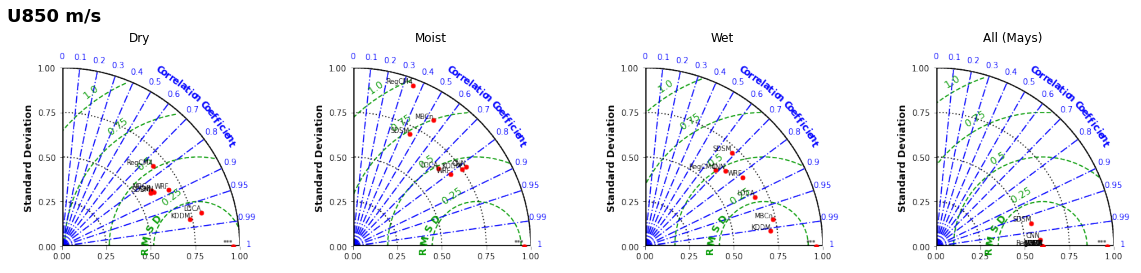

<Figure size 432x288 with 0 Axes>

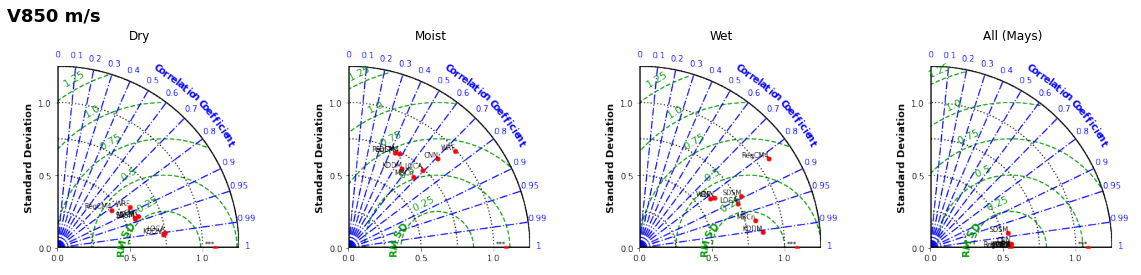

<Figure size 432x288 with 0 Axes>

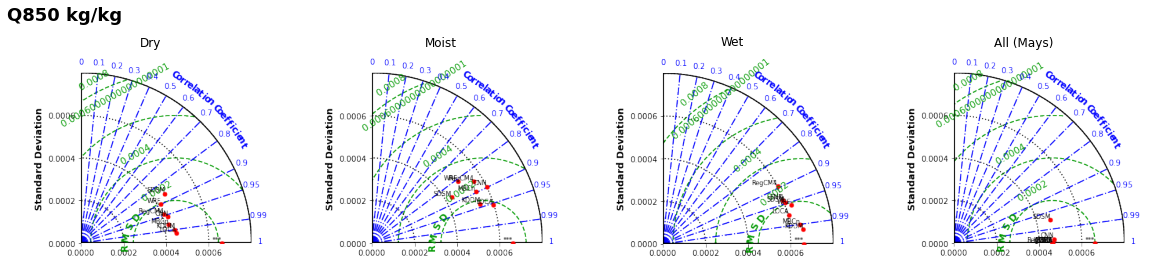

<Figure size 432x288 with 0 Axes>

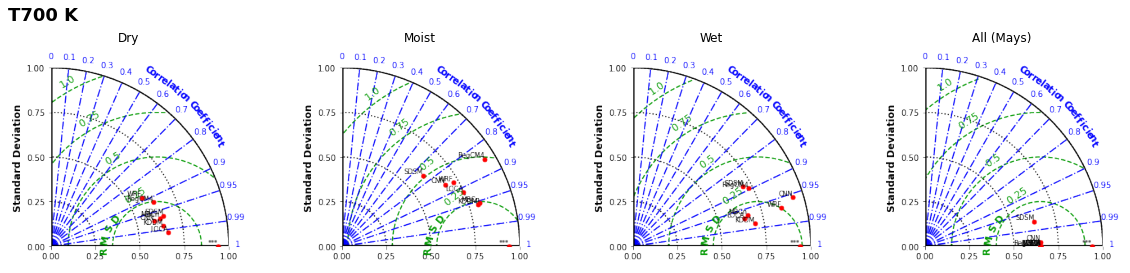

<Figure size 432x288 with 0 Axes>

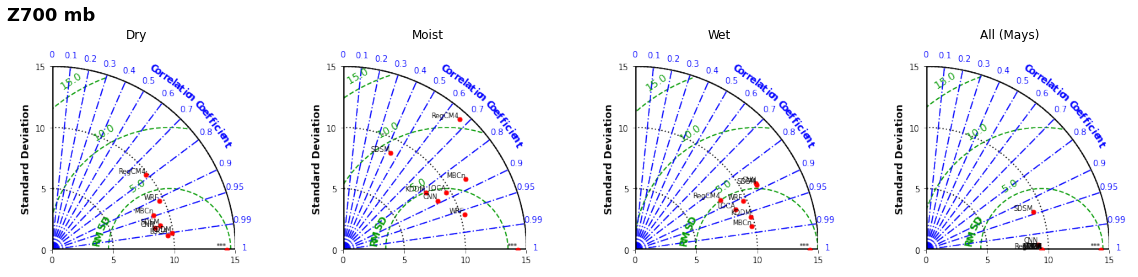

<Figure size 432x288 with 0 Axes>

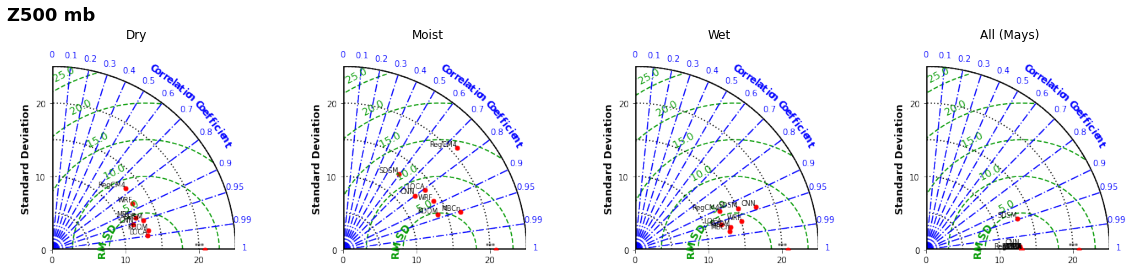

<Figure size 432x288 with 0 Axes>

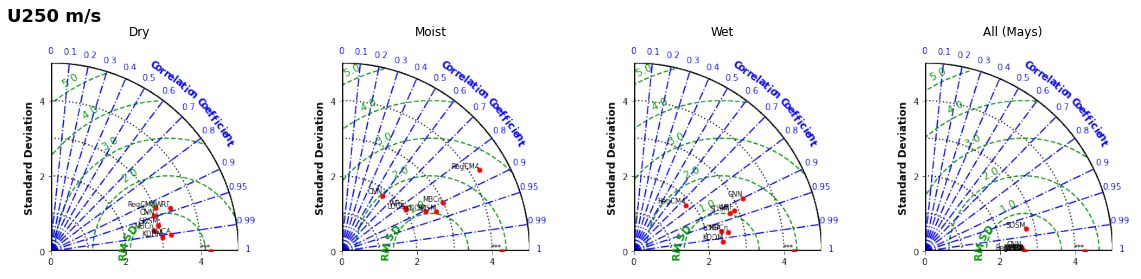

<Figure size 432x288 with 0 Axes>

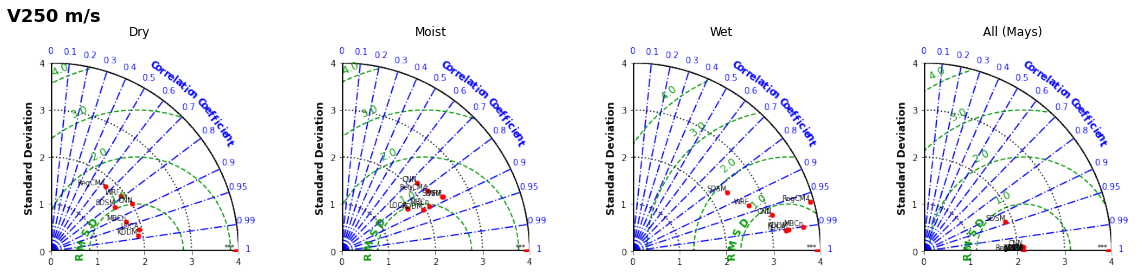

In [201]:
# Plot Taylor plots
import skill_metrics as sm

# save plot as png in a fake in-memory file
import io, base64
from PIL import Image
import cv2

varmames = ['U850', 'V850', 'Q850', 'T700', 'Z700', 'Z500', 'U250', 'V250']
units = ['m/s', 'm/s', 'kg/kg', 'K', 'mb', 'mb', 'm/s', 'm/s']


for vii in range(8):
    # fake files to write to
    buf1 = io.BytesIO()
    buf2 = io.BytesIO()
    buf3 = io.BytesIO()
    buf4 = io.BytesIO()
    
    #print("Variable: ", varmames[vii], units[vii])
    
    # min/max for entire row
    maxxx = np.array(XX)[:,vii,:].max()
    maxxy = np.array(YY)[:,vii,:].max()
    maxxz = np.array(ZZ)[:,vii,:].max()
    #print(maxxx, maxxy, maxxz)

    aa = np.concatenate([np.array(XX)[:,vii,0], [maxxx]])
    bb = np.concatenate([np.array(YY)[:,vii,0], [maxxy]])
    cc = np.concatenate([np.array(ZZ)[:,vii,0], [maxxz]])
    dd = names + ['***']
    sm.taylor_diagram(aa, bb, cc, markerLabel=dd)
    #sm.taylor_diagram(np.array(XX)[:,vii,0], np.array(YY)[:,vii,0], np.array(ZZ)[:,vii,0], markerLabel=names)
    plt.savefig(buf1, format='png', bbox_inches='tight')
    plt.clf()   # Clear figure

    aa = np.concatenate([np.array(XX)[:,vii,1], [maxxx]])
    bb = np.concatenate([np.array(YY)[:,vii,1], [maxxy]])
    cc = np.concatenate([np.array(ZZ)[:,vii,1], [maxxz]])
    dd = names + ['***']
    sm.taylor_diagram(aa, bb, cc, markerLabel=dd)
    #sm.taylor_diagram(np.array(XX)[:,vii,1], np.array(YY)[:,vii,1], np.array(ZZ)[:,vii,1], markerLabel=names)
    plt.savefig(buf2, format='png', bbox_inches='tight')
    plt.clf()   # Clear figure

    aa = np.concatenate([np.array(XX)[:,vii,2], [maxxx]])
    bb = np.concatenate([np.array(YY)[:,vii,2], [maxxy]])
    cc = np.concatenate([np.array(ZZ)[:,vii,2], [maxxz]])
    dd = names + ['***']
    sm.taylor_diagram(aa, bb, cc, markerLabel=dd)
    #sm.taylor_diagram(np.array(XX)[:,vii,2], np.array(YY)[:,vii,2], np.array(ZZ)[:,vii,2], markerLabel=names)
    plt.savefig(buf3, format='png', bbox_inches='tight')
    plt.clf()   # Clear figure

    aa = np.concatenate([np.array(XX)[:,vii,3], [maxxx]])
    bb = np.concatenate([np.array(YY)[:,vii,3], [maxxy]])
    cc = np.concatenate([np.array(ZZ)[:,vii,3], [maxxz]])
    dd = names + ['***']
    sm.taylor_diagram(aa, bb, cc, markerLabel=dd)
    #sm.taylor_diagram(np.array(XX)[:,vii,3], np.array(YY)[:,vii,3], np.array(ZZ)[:,vii,3], markerLabel=names)
    plt.savefig(buf4, format='png', bbox_inches='tight')
    plt.clf()   # Clear figure

    # load png
    buf1.seek(0)
    buf2.seek(0)
    buf3.seek(0)
    buf4.seek(0)
    img1 = Image.open(buf1)
    img2 = Image.open(buf2)
    img3 = Image.open(buf3)
    img4 = Image.open(buf4)

    # plot png inside a grid layout
    fig, axarr = plt.subplots(nrows=1, ncols=4, figsize = (20,20/4))

    axarr[0].imshow(img1)
    #axarr[0].axis('tight')
    axarr[0].axis('off')
    axarr[0].set_title('Dry')

    axarr[1].imshow(img2)
    axarr[1].axis('off')
    axarr[1].set_title('Moist')

    axarr[2].imshow(img3)
    axarr[2].axis('off')
    axarr[2].set_title('Wet')
    
    axarr[3].imshow(img4)
    axarr[3].axis('off')
    axarr[3].set_title('All (Mays)')
    
    # title
    fig.suptitle(str(varmames[vii])+' '+str(units[vii]), y=0.92, x=.15, fontsize=18, fontweight="bold")
    
    plt.show()


# Hist anomalies

In [185]:
# # Calculate parameters for Taylor plots: Historical anomalies for dry/moist/wet/all

# names = ['raw','RegCM4','WRF','CNN','SDSM','KDDM','MBCn','LOCA']
# sigfiles_hist = [model2absfilepath(ff, 'hist', 98, 36) for ff in ['raw','RegCM4','WRF','CNN','SDSM','KDDM','MBCn','LOCA']]
# sigfiles_rcp85 = [model2absfilepath(ff, 'rcp85', 98, 36) for ff in ['raw','RegCM4','WRF','CNN','SDSM','KDDM','MBCn','LOCA']]

# # interate over models
# HAXX=[]; HAYY=[]; HAZZ=[]
# for mii in range(len(sigfiles_hist)):
#     sigfn1 = sigfiles_hist[mii]
#     sigfn2 = sigfiles_rcp85[mii]

#     rainsignal1 = xr.open_dataset(sigfn1)['prec']
#     rainsignal2 = xr.open_dataset(sigfn2)['prec']

#     X=[]
#     load_uatm_mpi_hist()
#     for mpr_min, mpr_max in [(0,0.254), (0.254, 3.0), (3.0, 9999.0), (0, 9999.0)]:
#         avginput_hist, count1, distribution1, indices1 = calc_uatm_average(mpr_min, mpr_max, rainsignal1, 5, -9999, 9999) 
#         #avginput1, count1, distribution1, indices1 = calc_prec_average(0, 0.254, rainsignal2, 5, -9999, 9999) 
#         X.append(avginput_hist)
    
#     Y=[]
#     load_uatm_mpi_future()
#     for mpr_min, mpr_max in [(0,0.254), (0.254, 3.0), (3.0, 9999.0), (0, 9999.0)]:
#         avginput_rcp85, count2, distribution2, indices2 = calc_uatm_average(mpr_min, mpr_max, rainsignal2, 5, -9999, 9999) 
#         Y.append(avginput_rcp85)
        
#     sd83=[]; cr83=[]; sc83=[]
#     for vii in range(8):
#         sd3=[]; cr3=[]; sc3=[]
#         for ii in range(4):
            
#             diff = X[ii] - X[3]
            
#             #sd = np.std(rainsignal1[:,0,0] - rainsignal2[:,0,0])
#             sd = np.std(diff[vii])
#             cr = ((diff[vii]-baseline[ii][vii])**2).mean()**0.5
#             sc, delme = spearmanr(baseline[ii][vii].flatten(),diff[vii].flatten())
#             sd3.append(float(sd))
#             cr3.append(float(cr))
#             sc3.append(float(sc))
#             #print(mii, vii, float(sd), float(cr), float(sc))
#         sd83.append(sd3)
#         cr83.append(cr3)
#         sc83.append(sc3)

#     HAXX.append(sd83)
#     HAYY.append(cr83)
#     HAZZ.append(sc83)


In [183]:
# Calculate parameters for Taylor plots: Historical anomalies for dry/moist/wet/all

names = ['raw','RegCM4','WRF','CNN','SDSM','KDDM','MBCn','LOCA']
sigfiles_hist = [model2absfilepath(ff, 'hist', 98, 36) for ff in ['raw','RegCM4','WRF','CNN','SDSM','KDDM','MBCn','LOCA']]


# interate over models
HAXX=[]; HAYY=[]; HAZZ=[]
for mii in range(len(sigfiles_hist)):
    sigfn1 = sigfiles_hist[mii]
    rainsignal1 = xr.open_dataset(sigfn1)['prec']
            
    X=[]
    load_uatm_mpi_hist()
    for mpr_min, mpr_max in [(0,0.254), (0.254, 3.0), (3.0, 9999.0), (0, 9999.0)]:
        avginput_hist, count1, distribution1, indices1 = calc_uatm_average(mpr_min, mpr_max, rainsignal1, 5, -9999, 9999) 
        X.append(avginput_hist)
   
    # baseline: raw
    if mii == 0:
        baseline_hist = np.array(X[3])
 
    sd83=[]; cr83=[]; sc83=[]
    for vii in range(8):
        sd3=[]; cr3=[]; sc3=[]
        for ii in range(4):            
            #sd = np.std(rainsignal1[:,0,0] - rainsignal2[:,0,0])
            #cr = ((diff[vii]-baseline[ii][vii])**2).mean()**0.5
            #sc, delme = spearmanr(baseline[ii][vii].flatten(),diff[vii].flatten())
            
            sd = np.std(np.array(Y[ii][vii]) - baseline_hist[vii])
            cr = ((np.array(X[ii][vii]) - baseline_hist[vii])**2).mean()**0.5            
            sc, delme = spearmanr(baseline_hist[vii].flatten(), np.array(X[ii][vii]).flatten())
            
            sd3.append(float(sd))
            cr3.append(float(cr))
            sc3.append(float(sc))
            #print(mii, vii, float(sd), float(cr), float(sc))
        sd83.append(sd3)
        cr83.append(cr3)
        sc83.append(sc3)
        
    HAXX.append(sd83)
    HAYY.append(cr83)
    HAZZ.append(sc83)

<Figure size 432x288 with 0 Axes>

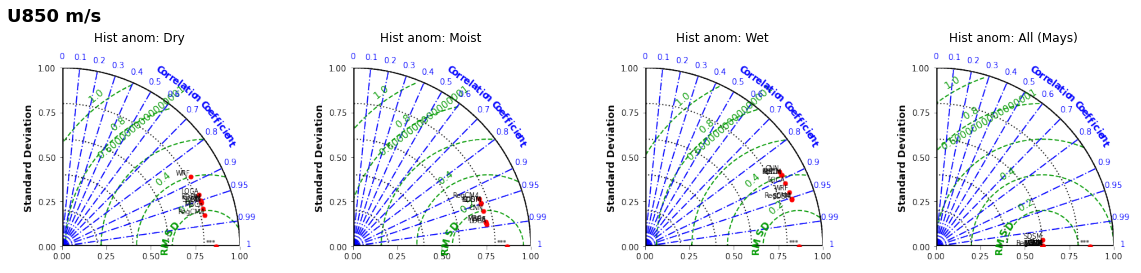

<Figure size 432x288 with 0 Axes>

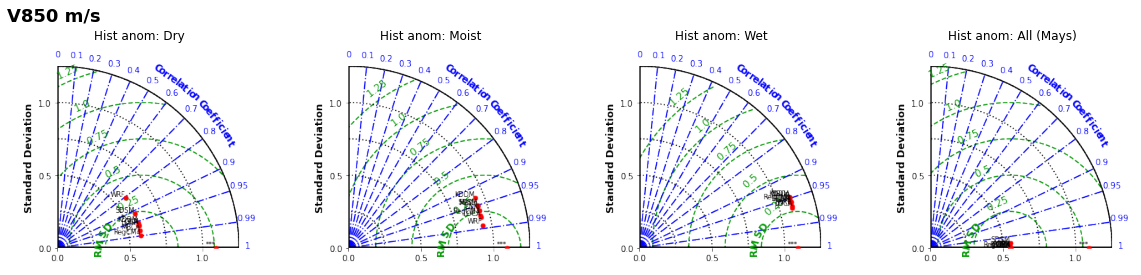

<Figure size 432x288 with 0 Axes>

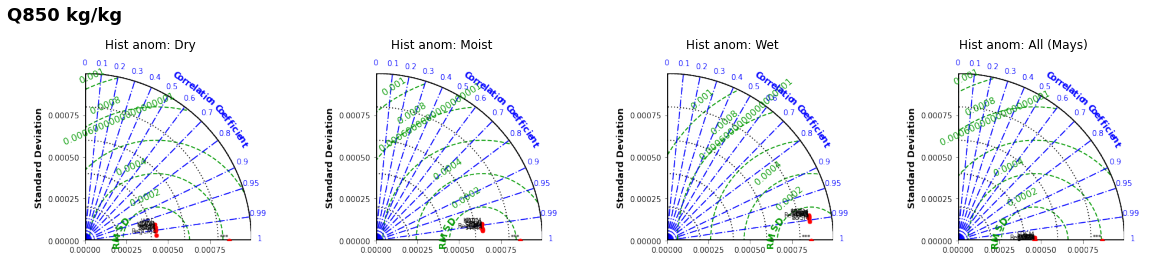

<Figure size 432x288 with 0 Axes>

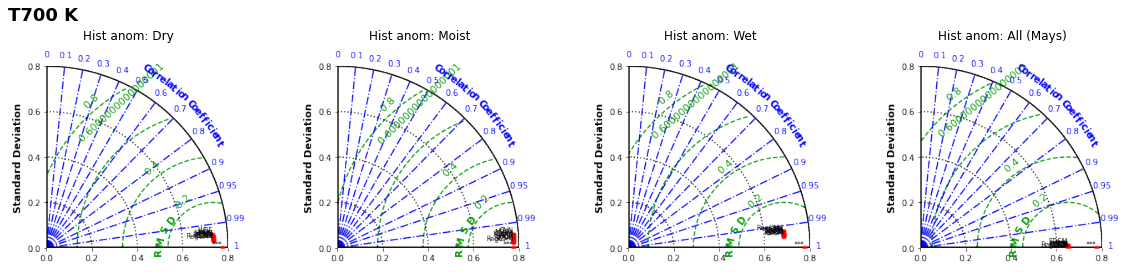

<Figure size 432x288 with 0 Axes>

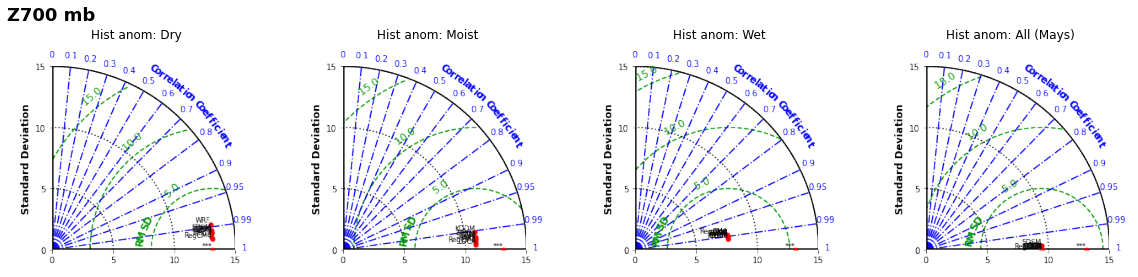

<Figure size 432x288 with 0 Axes>

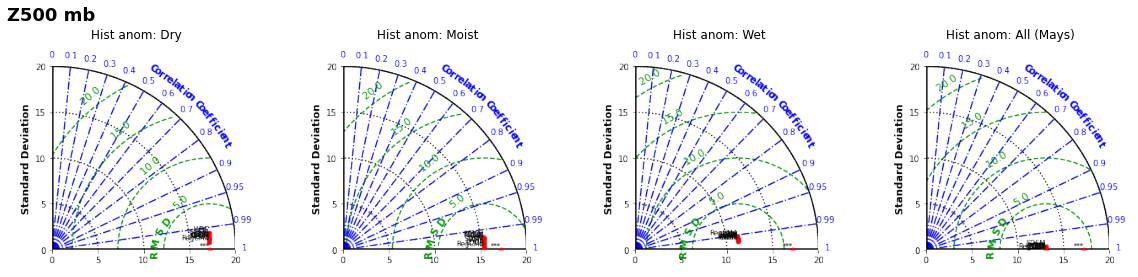

<Figure size 432x288 with 0 Axes>

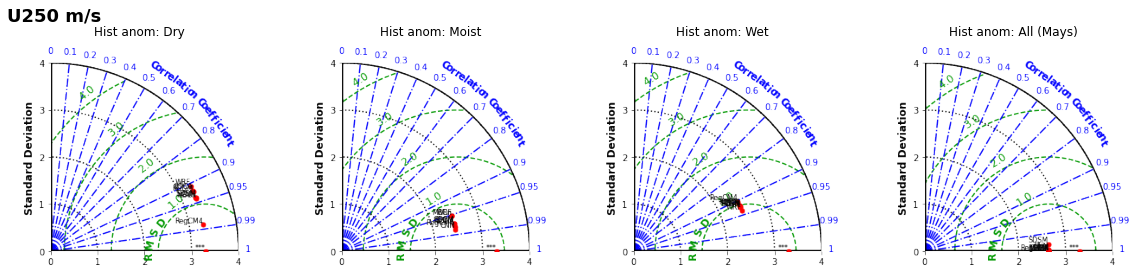

<Figure size 432x288 with 0 Axes>

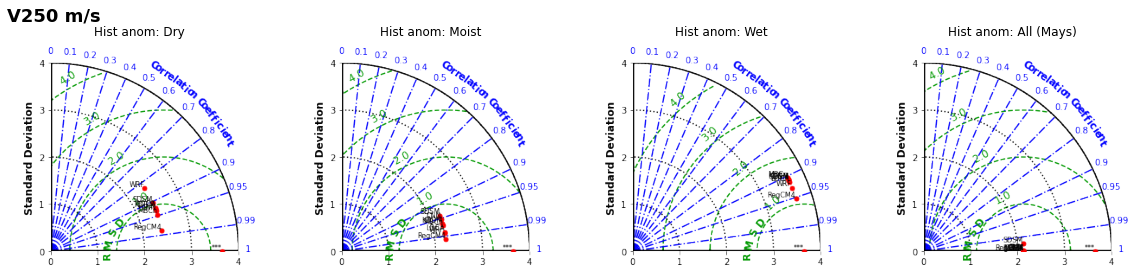

In [198]:
# Plot hist anomalies
# Plot Taylor plots
import skill_metrics as sm

# save plot as png in a fake in-memory file
import io, base64
from PIL import Image
import cv2

varmames = ['U850', 'V850', 'Q850', 'T700', 'Z700', 'Z500', 'U250', 'V250']
units = ['m/s', 'm/s', 'kg/kg', 'K', 'mb', 'mb', 'm/s', 'm/s']


for vii in range(8):
    # fake files to write to
    buf1 = io.BytesIO()
    buf2 = io.BytesIO()
    buf3 = io.BytesIO()
    buf4 = io.BytesIO()
    
    #print("Variable: ", varmames[vii], units[vii])
    
    # min/max
    maxxx = np.array(HAXX)[:,vii,:].max()
    maxxy = np.array(HAYY)[:,vii,:].max()
    maxxz = np.array(HAZZ)[:,vii,:].max()
    #print(maxxx, maxxy, maxxz)


    aa = np.concatenate([np.array(HAXX)[:,vii,0], [maxxx]])
    bb = np.concatenate([np.array(HAYY)[:,vii,0], [maxxy]])
    cc = np.concatenate([np.array(HAZZ)[:,vii,0], [maxxz]])
    dd = names + ['***']
    sm.taylor_diagram(aa, bb, cc, markerLabel=dd)
    #sm.taylor_diagram(np.array(HAXX)[:,vii,0], np.array(HAYY)[:,vii,0], np.array(HAZZ)[:,vii,0], markerLabel=names)
    plt.savefig(buf1, format='png', bbox_inches='tight')
    plt.clf()   # Clear figure

    aa = np.concatenate([np.array(HAXX)[:,vii,1], [maxxx]])
    bb = np.concatenate([np.array(HAYY)[:,vii,1], [maxxy]])
    cc = np.concatenate([np.array(HAZZ)[:,vii,1], [maxxz]])
    dd = names + ['***']
    sm.taylor_diagram(aa, bb, cc, markerLabel=dd)
    #sm.taylor_diagram(np.array(HAXX)[:,vii,1], np.array(HAYY)[:,vii,1], np.array(HAZZ)[:,vii,1], markerLabel=names)
    plt.savefig(buf2, format='png', bbox_inches='tight')
    plt.clf()   # Clear figure

    aa = np.concatenate([np.array(HAXX)[:,vii,2], [maxxx]])
    bb = np.concatenate([np.array(HAYY)[:,vii,2], [maxxy]])
    cc = np.concatenate([np.array(HAZZ)[:,vii,2], [maxxz]])
    dd = names + ['***']
    sm.taylor_diagram(aa, bb, cc, markerLabel=dd)
    #sm.taylor_diagram(np.array(HAXX)[:,vii,2], np.array(HAYY)[:,vii,2], np.array(HAZZ)[:,vii,2], markerLabel=names)
    plt.savefig(buf3, format='png', bbox_inches='tight')
    plt.clf()   # Clear figure

    aa = np.concatenate([np.array(HAXX)[:,vii,3], [maxxx]])
    bb = np.concatenate([np.array(HAYY)[:,vii,3], [maxxy]])
    cc = np.concatenate([np.array(HAZZ)[:,vii,3], [maxxz]])
    dd = names + ['***']
    sm.taylor_diagram(aa, bb, cc, markerLabel=dd)
    #sm.taylor_diagram(np.array(HAXX)[:,vii,3], np.array(HAYY)[:,vii,3], np.array(HAZZ)[:,vii,3], markerLabel=names)
    plt.savefig(buf4, format='png', bbox_inches='tight')
    plt.clf()   # Clear figure

    # load png
    buf1.seek(0)
    buf2.seek(0)
    buf3.seek(0)
    buf4.seek(0)
    img1 = Image.open(buf1)
    img2 = Image.open(buf2)
    img3 = Image.open(buf3)
    img4 = Image.open(buf4)

    # plot png inside a grid layout
    fig, axarr = plt.subplots(nrows=1, ncols=4, figsize = (20,20/4))

    axarr[0].imshow(img1)
    #axarr[0].axis('tight')
    axarr[0].axis('off')
    axarr[0].set_title('Hist anom: Dry')

    axarr[1].imshow(img2)
    axarr[1].axis('off')
    axarr[1].set_title('Hist anom: Moist')

    axarr[2].imshow(img3)
    axarr[2].axis('off')
    axarr[2].set_title('Hist anom: Wet')
    
    axarr[3].imshow(img4)
    axarr[3].axis('off')
    axarr[3].set_title('Hist anom: All (Mays)')
    
    # title
    fig.suptitle(str(varmames[vii])+' '+str(units[vii]), y=0.92, x=.15, fontsize=18, fontweight="bold")

    plt.show()

# Future anomalies

In [186]:
# Calculate parameters for Taylor plots: dry/moist/wet

names = ['raw','RegCM4','WRF','CNN','SDSM','KDDM','MBCn','LOCA']
sigfiles_rcp85 = [model2absfilepath(ff, 'rcp85', 98, 36) for ff in ['raw','RegCM4','WRF','CNN','SDSM','KDDM','MBCn','LOCA']]

# interate over models
FAXX=[]; FAYY=[]; FAZZ=[]
for mii in range(len(sigfiles_rcp85)):
    sigfn2 = sigfiles_rcp85[mii]
    rainsignal2 = xr.open_dataset(sigfn2)['prec']
            
    Y=[]
    load_uatm_mpi_future()
    for mpr_min, mpr_max in [(0,0.254), (0.254, 3.0), (3.0, 9999.0), (0, 9999.0)]:
        avginput_rcp85, count2, distribution2, indices2 = calc_uatm_average(mpr_min, mpr_max, rainsignal2, 5, -9999, 9999) 
        Y.append(avginput_rcp85)
   
    # baseline: raw
    if mii == 0:
        baseline_future = np.array(Y[3])

 
    sd83=[]; cr83=[]; sc83=[]
    for vii in range(8):
        sd3=[]; cr3=[]; sc3=[]
        for ii in range(4):            
            #sd = np.std(rainsignal1[:,0,0] - rainsignal2[:,0,0])
            #cr = ((diff[vii]-baseline[ii][vii])**2).mean()**0.5
            #sc, delme = spearmanr(baseline[ii][vii].flatten(),diff[vii].flatten())
            
            sd = np.std(np.array(Y[ii][vii]) - baseline_future[vii])
            cr = ((np.array(Y[ii][vii]) - baseline_future[vii])**2).mean()**0.5            
            sc, delme = spearmanr(baseline_future[vii].flatten(), np.array(Y[ii][vii]).flatten())
            
            sd3.append(float(sd))
            cr3.append(float(cr))
            sc3.append(float(sc))
            print(mii, vii, float(sd), float(cr), float(sc))
        sd83.append(sd3)
        cr83.append(cr3)
        sc83.append(sc3)
        
    FAXX.append(sd83)
    FAYY.append(cr83)
    FAZZ.append(sc83)

<Figure size 432x288 with 0 Axes>

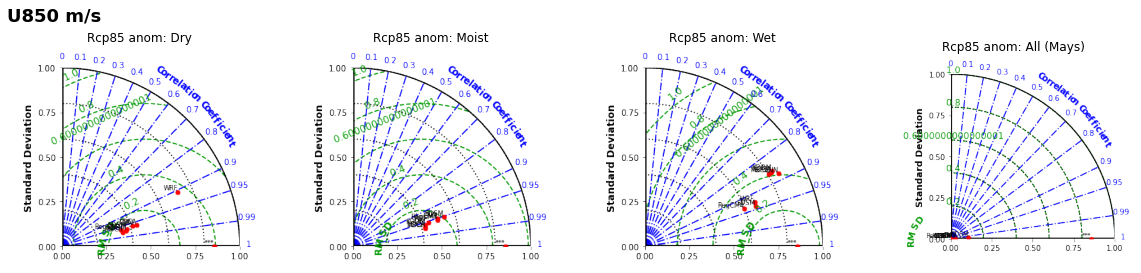

<Figure size 432x288 with 0 Axes>

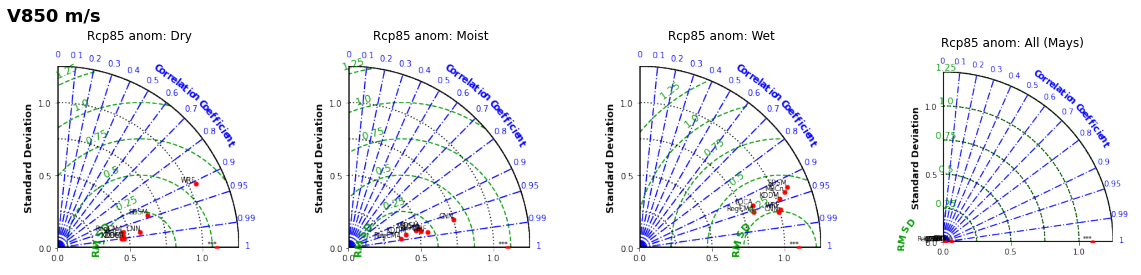

<Figure size 432x288 with 0 Axes>

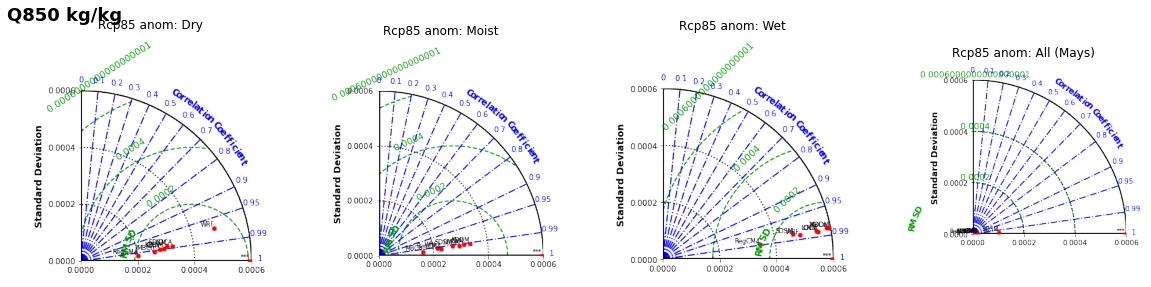

<Figure size 432x288 with 0 Axes>

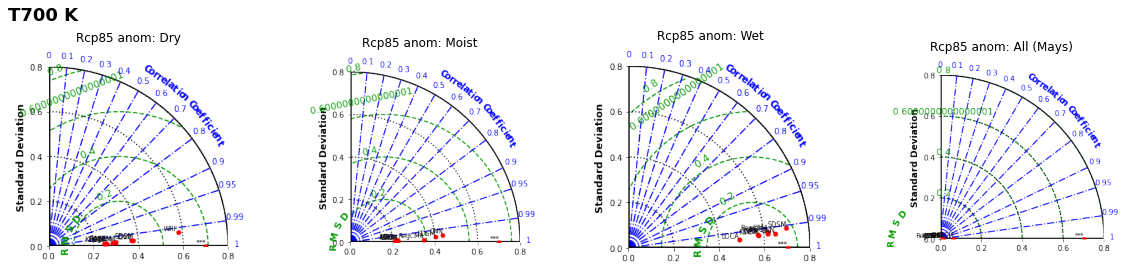

<Figure size 432x288 with 0 Axes>

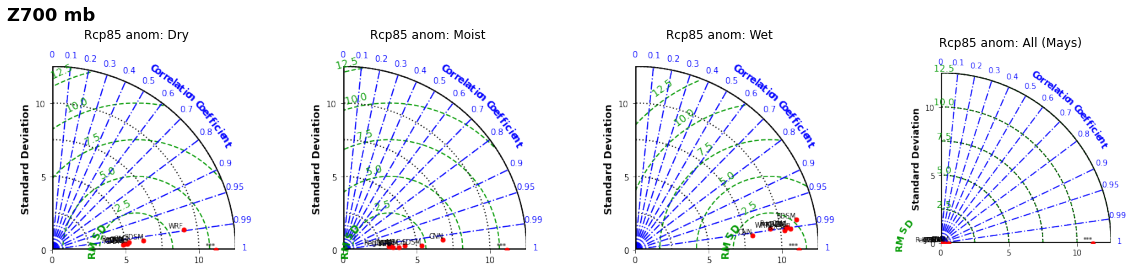

<Figure size 432x288 with 0 Axes>

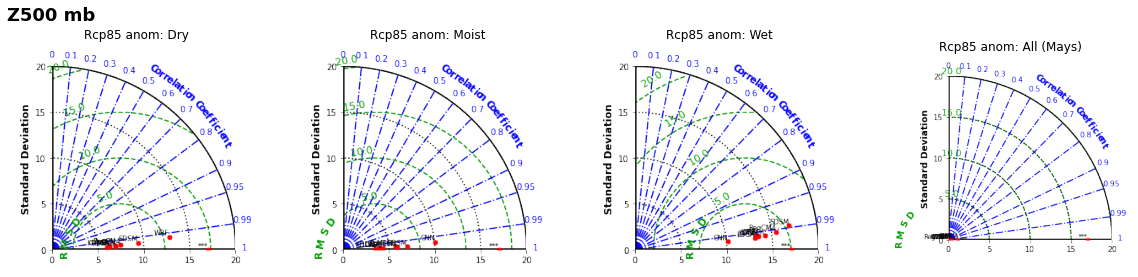

<Figure size 432x288 with 0 Axes>

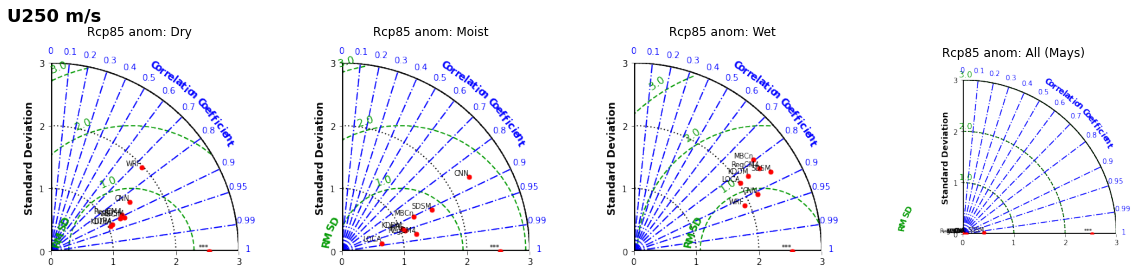

<Figure size 432x288 with 0 Axes>

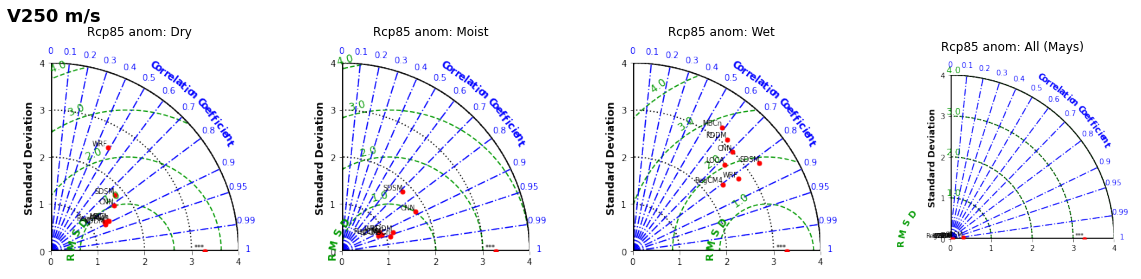

In [192]:
# Plot Future anomalies
# Plot Taylor plots
import skill_metrics as sm

# save plot as png in a fake in-memory file
import io, base64
from PIL import Image
import cv2

varmames = ['U850', 'V850', 'Q850', 'T700', 'Z700', 'Z500', 'U250', 'V250']
units = ['m/s', 'm/s', 'kg/kg', 'K', 'mb', 'mb', 'm/s', 'm/s']


for vii in range(8):
    # fake files to write to
    buf1 = io.BytesIO()
    buf2 = io.BytesIO()
    buf3 = io.BytesIO()
    buf4 = io.BytesIO()
    
    #print("Variable: ", varmames[vii], units[vii])
    
    # min/max
    maxxx = np.array(FAXX)[:,vii,:].max()
    maxxy = np.array(FAYY)[:,vii,:].max()
    maxxz = np.array(FAZZ)[:,vii,:].max()
    #print(maxxx, maxxy, maxxz)

    aa = np.concatenate([np.array(FAXX)[:,vii,0], [maxxx]])
    bb = np.concatenate([np.array(FAYY)[:,vii,0], [maxxy]])
    cc = np.concatenate([np.array(FAZZ)[:,vii,0], [maxxz]])
    dd = names + ['***']
    sm.taylor_diagram(aa, bb, cc, markerLabel=dd)
    plt.savefig(buf1, format='png', bbox_inches='tight')
    plt.clf()   # Clear figure

    aa = np.concatenate([np.array(FAXX)[:,vii,1], [maxxx]])
    bb = np.concatenate([np.array(FAYY)[:,vii,1], [maxxy]])
    cc = np.concatenate([np.array(FAZZ)[:,vii,1], [maxxz]])
    dd = names + ['***']
    #sm.taylor_diagram(np.array(FAXX)[:,vii,1], np.array(FAYY)[:,vii,1], np.array(FAZZ)[:,vii,1], markerLabel=names)
    sm.taylor_diagram(aa, bb, cc, markerLabel=dd)
    plt.savefig(buf2, format='png', bbox_inches='tight')
    plt.clf()   # Clear figure

    aa = np.concatenate([np.array(FAXX)[:,vii,2], [maxxx]])
    bb = np.concatenate([np.array(FAYY)[:,vii,2], [maxxy]])
    cc = np.concatenate([np.array(FAZZ)[:,vii,2], [maxxz]])
    dd = names + ['***']
    #sm.taylor_diagram(np.array(FAXX)[:,vii,2], np.array(FAYY)[:,vii,2], np.array(FAZZ)[:,vii,2], markerLabel=names)
    sm.taylor_diagram(aa, bb, cc, markerLabel=dd)
    plt.savefig(buf3, format='png', bbox_inches='tight')
    plt.clf()   # Clear figure

    aa = np.concatenate([np.array(FAXX)[:,vii,3], [maxxx]])
    bb = np.concatenate([np.array(FAYY)[:,vii,3], [maxxy]])
    cc = np.concatenate([np.array(FAZZ)[:,vii,3], [maxxz]])
    dd = names + ['***']
    #sm.taylor_diagram(np.array(FAXX)[:,vii,3], np.array(FAYY)[:,vii,3], np.array(FAZZ)[:,vii,3], markerLabel=names)
    sm.taylor_diagram(aa, bb, cc, markerLabel=dd)
    plt.savefig(buf4, format='png', bbox_inches='tight')
    plt.clf()   # Clear figure

    # load png
    buf1.seek(0)
    buf2.seek(0)
    buf3.seek(0)
    buf4.seek(0)
    img1 = Image.open(buf1)
    img2 = Image.open(buf2)
    img3 = Image.open(buf3)
    img4 = Image.open(buf4)

    # plot png inside a grid layout
    fig, axarr = plt.subplots(nrows=1, ncols=4, figsize = (20,20/4))

    axarr[0].imshow(img1)
    #axarr[0].axis('tight')
    axarr[0].axis('off')
    axarr[0].set_title('Rcp85 anom: Dry')

    axarr[1].imshow(img2)
    axarr[1].axis('off')
    axarr[1].set_title('Rcp85 anom: Moist')

    axarr[2].imshow(img3)
    axarr[2].axis('off')
    axarr[2].set_title('Rcp85 anom: Wet')
    
    axarr[3].imshow(img4)
    axarr[3].axis('off')
    axarr[3].set_title('Rcp85 anom: All (Mays)')
    
    # title
    fig.suptitle(str(varmames[vii])+' '+str(units[vii]), y=0.92, x=.15, fontsize=18, fontweight="bold")
    

    plt.show()

### option experiments

In [169]:
np.concatenate([np.array([1,2]), [3,4]])

array([1, 2, 3, 4])

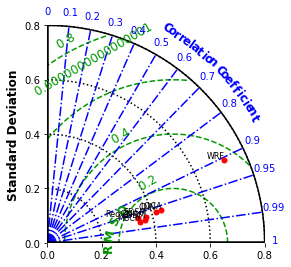

In [127]:
sm.taylor_diagram(np.array(FAXX)[:,0,0], np.array(FAYY)[:,0,0], np.array(FAZZ)[:,0,0], markerLabel=names)


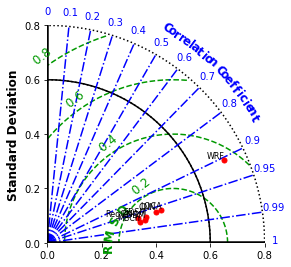

In [162]:
sm.taylor_diagram(np.array(FAXX)[:,0,0], np.array(FAYY)[:,0,0], np.array(FAZZ)[:,0,0], markerLabel=names, tickRMS=[.2,.4,.6,.8], tickSTD=[.6, .6])
